In [1]:
import numpy as np
import sep

Getting the modules to create the image and setting up the basic parameters:

In [2]:
# additional setup for reading the test image and displaying plots
import astropy.io.fits
import matplotlib.pyplot as plt
from matplotlib import rcParams

%matplotlib inline

rcParams['figure.figsize'] = [10., 8.]

Getting the data from the file:

In [3]:
# read image into standard 2-d numpy array
data = astropy.io.fits.getdata(r"C:\Users\emmag\Documents\astro 19\hlsp_hudf12_hst_wfc3ir_udfmain_f105w_v1.0_drz.fits")

Turning the file into a grayscale image:

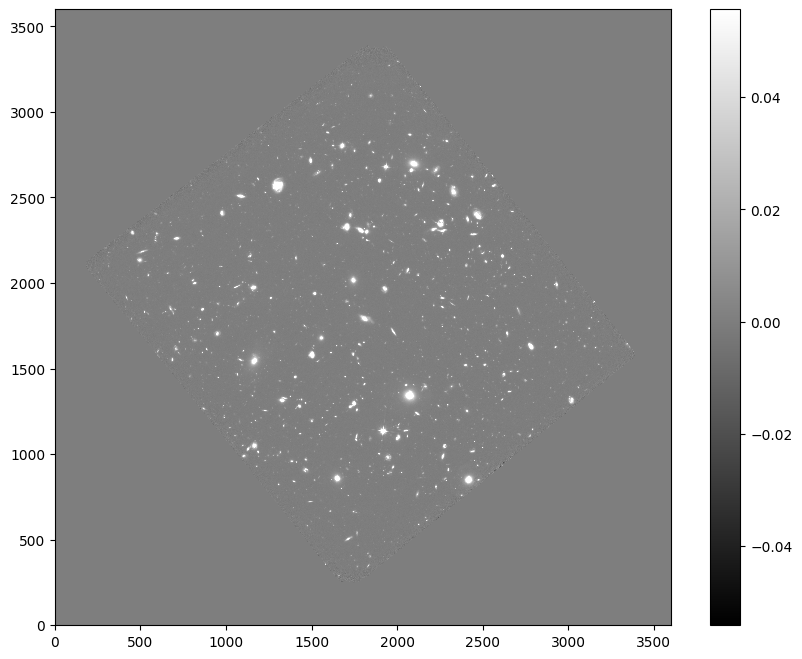

In [4]:
m, s = np.mean(data), np.std(data)
plt.imshow(data, interpolation='nearest', cmap='gray', vmin=m-s, vmax=m+s, origin='lower')
plt.colorbar();
plt.savefig('HUDF_1.png')

Getting the general "color" of the background. I had to switch the byte order, apparently.

In [5]:
data = data.byteswap().newbyteorder()
bkg = sep.Background(data)

Finding the mean and noise of the background "color":

In [6]:
print(bkg.globalback)
print(bkg.globalrms)

0.0
0.0005398219218477607


Evaluating the background as a 2d array:

In [7]:
bkg_image = bkg.back()

Showing the background after all the stuff done to it:

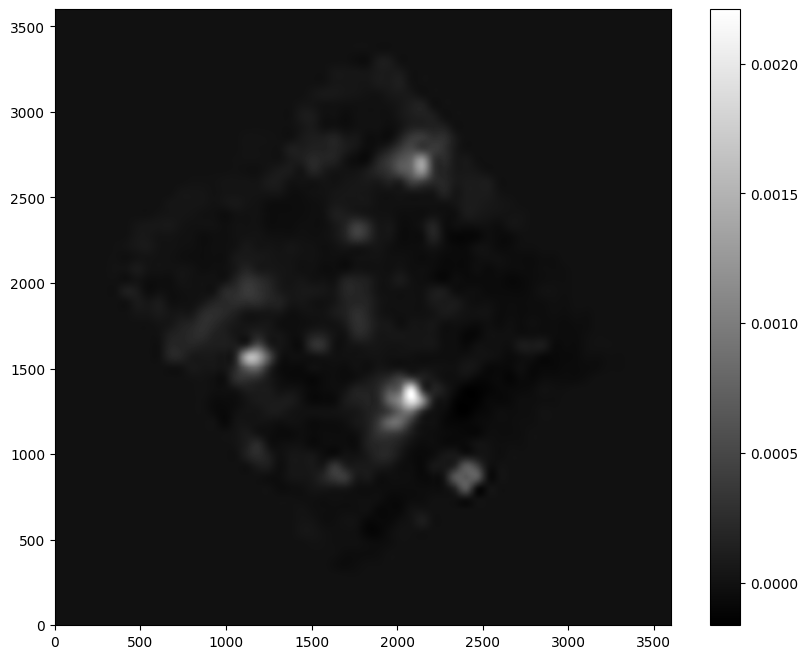

In [8]:
plt.imshow(bkg_image, interpolation='nearest', cmap='gray', origin='lower')
plt.colorbar();
plt.savefig('HUDF_2.png')

This time, making the background NOISE into a 2d array:

In [9]:
bkg_rms = bkg.rms()

Showing the noise:

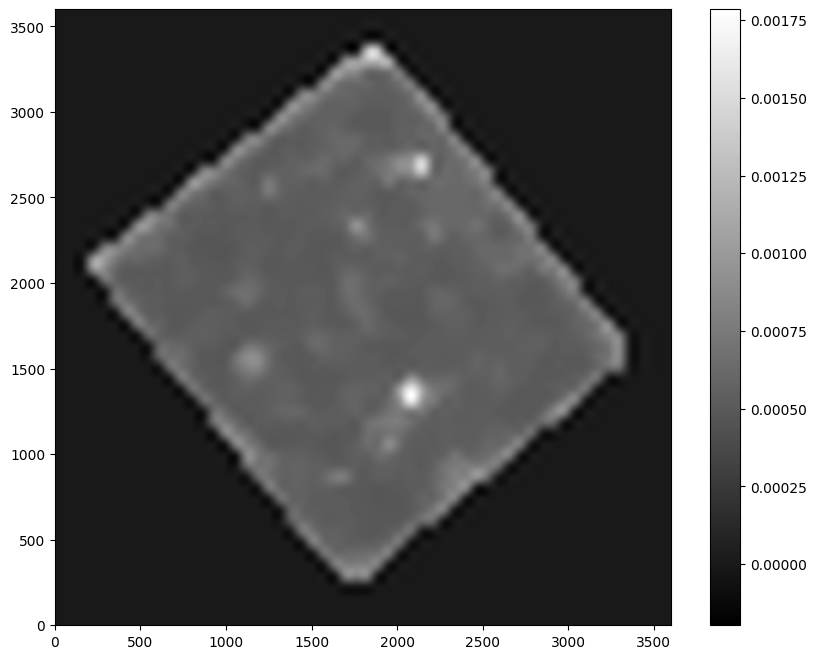

In [10]:
plt.imshow(bkg_rms, interpolation='nearest', cmap='gray', origin='lower')
plt.colorbar();
plt.savefig('HUDF_3.png')

Subtract the background from the initial data in order to isolate the objects:

In [11]:
data_sub = data - bkg
objects = sep.extract(data_sub, 1.5, err=bkg.globalrms)

Finding how many objects there are in the image:

In [24]:
print(f"There are {len(objects)} objects in the image.")

There are 8640 objects in the image.


Plotting the initial image again, except this time circling all of the objects:

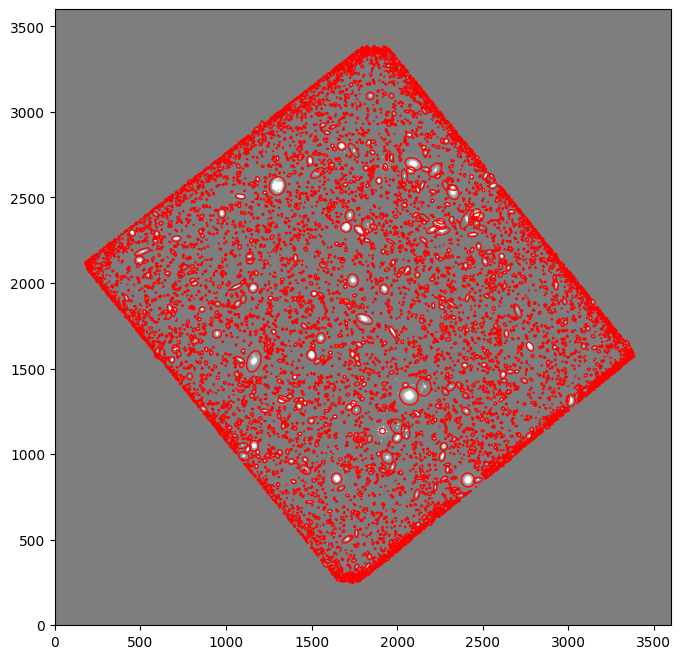

In [13]:
from matplotlib.patches import Ellipse

fig, ax = plt.subplots()
m, s = np.mean(data_sub), np.std(data_sub)
im = ax.imshow(data_sub, interpolation='nearest', cmap='gray',
               vmin=m-s, vmax=m+s, origin='lower')

# plot an ellipse for each object
for i in range(len(objects)):
    e = Ellipse(xy=(objects['x'][i], objects['y'][i]),
                width=6*objects['a'][i],
                height=6*objects['b'][i],
                angle=objects['theta'][i] * 180. / np.pi)
    e.set_facecolor('none')
    e.set_edgecolor('red')
    ax.add_artist(e)
plt.savefig('HUDF_4')

In [14]:
flux, fluxerr, flag = sep.sum_circle(data_sub, objects['x'], objects['y'],
                                     3.0, err=bkg.globalrms, gain=1.0)

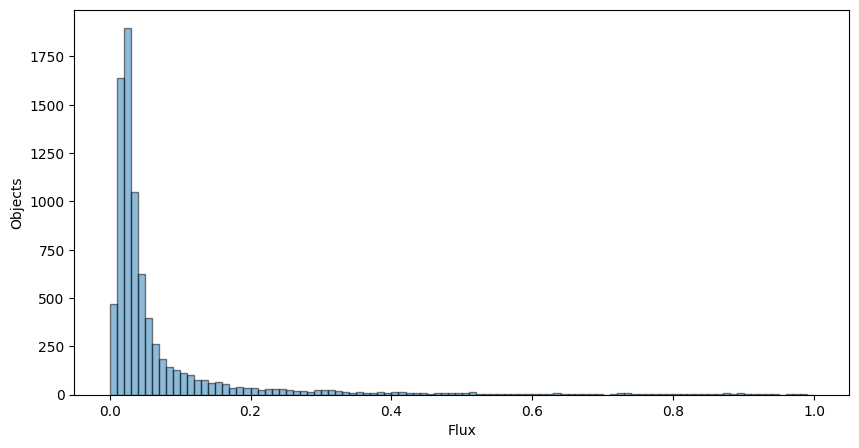

In [15]:
plt.figure(figsize=(10,5))
width=0.01
histmin=np.floor(min(flux))
histmax=np.ceil(max(flux))+width
bins=100
plt.hist(flux,bins=bins,alpha=.5,edgecolor='black',range=[0,1])
plt.xlabel('Flux')
plt.ylabel('Objects')
plt.xticks(ticks=(np.arange(0,1.2,.2)))
plt.savefig('hist_flux.png')
plt.show()

In [16]:
print(f"The mean of the fluxes is {np.mean(flux)}")
print(f"The median of the fluxes is {np.median(flux)}")
print(f"The standard deviation of the fluxes is {np.std(flux)}")

The mean of the fluxes is 0.36185728037707154
The median of the fluxes is 0.030960064365426664
The standard deviation of the fluxes is 9.243528029706706


Next step: find the outlier

In [17]:
print(f"The largest outlier has a flux of {max(flux)}. Wow!")
print(f"It is {max(flux)/np.std(flux)} standard deviations away from the mean.")
print("The location of it on the image is after the false-color image--it was hard to understand on the washed-out gray one.")

The largest outlier has a flux of 807.2972835731507. Wow!
It is 87.33648894433719 standard deviations away from the mean.
The location of it on the image is after the false-color image--it was hard to understand on the washed-out gray one.


This rescales the image: whereas before it looked totally black, this way we can actually see what's going on:

In [18]:
def rescale_img(data):
    pdata_tmp = data.copy()
    mean = np.nanmean(pdata_tmp)
    vplmin = mean / 2.
    vpmin = np.log10(vplmin)
    vpmax = np.log10(mean * 100.)
    pdata_tmp[pdata_tmp < vplmin] = vplmin
    pdata_tmp = np.log10(pdata_tmp)
    return pdata_tmp, vpmin, vpmax

I'm re-reading the first file along with the additional two images so I can have them nice all together:

In [19]:
data1 = astropy.io.fits.getdata(r"C:\Users\emmag\Documents\astro 19\hlsp_hudf12_hst_wfc3ir_udfmain_f105w_v1.0_drz.fits")
data2 = astropy.io.fits.getdata(r"C:\Users\emmag\Documents\astro 19\hlsp_hudf12_hst_wfc3ir_udfmain_f125w_v1.0_drz.fits")
data3 = astropy.io.fits.getdata(r"C:\Users\emmag\Documents\astro 19\hlsp_hudf12_hst_wfc3ir_udfmain_f160w_v1.0_drz.fits")

Gonna be real, I'm not sure what this does? I just obediently copied it from the slides. I DO know that it's redefining the maximums and minimums for...some reason. 

In [20]:
res1, min1, max1 = rescale_img(data1)
res2, min2, max2 = rescale_img(data2)
res3, min3, max3 = rescale_img(data3)

res1[res1 < min1] = min1
res1[res1 > max1] = max1
res2[res2 < min2] = min2
res2[res2 > max2] = max2
res3[res3 < min3] = min3
res3[res3 > max3] = max3

This assigns R, B, or G to each image.

In [21]:
rgb = np.zeros((res1.shape[0], res1.shape[1], 3))
rgb[:,:,0] = (res1 - min1) / (max1 - min1)
rgb[:,:,1] = (res2 - min2) / (max2 - min2)
rgb[:,:,2] = (res3 - min3) / (max3 - min3)

And it's finally time to plot the image!

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


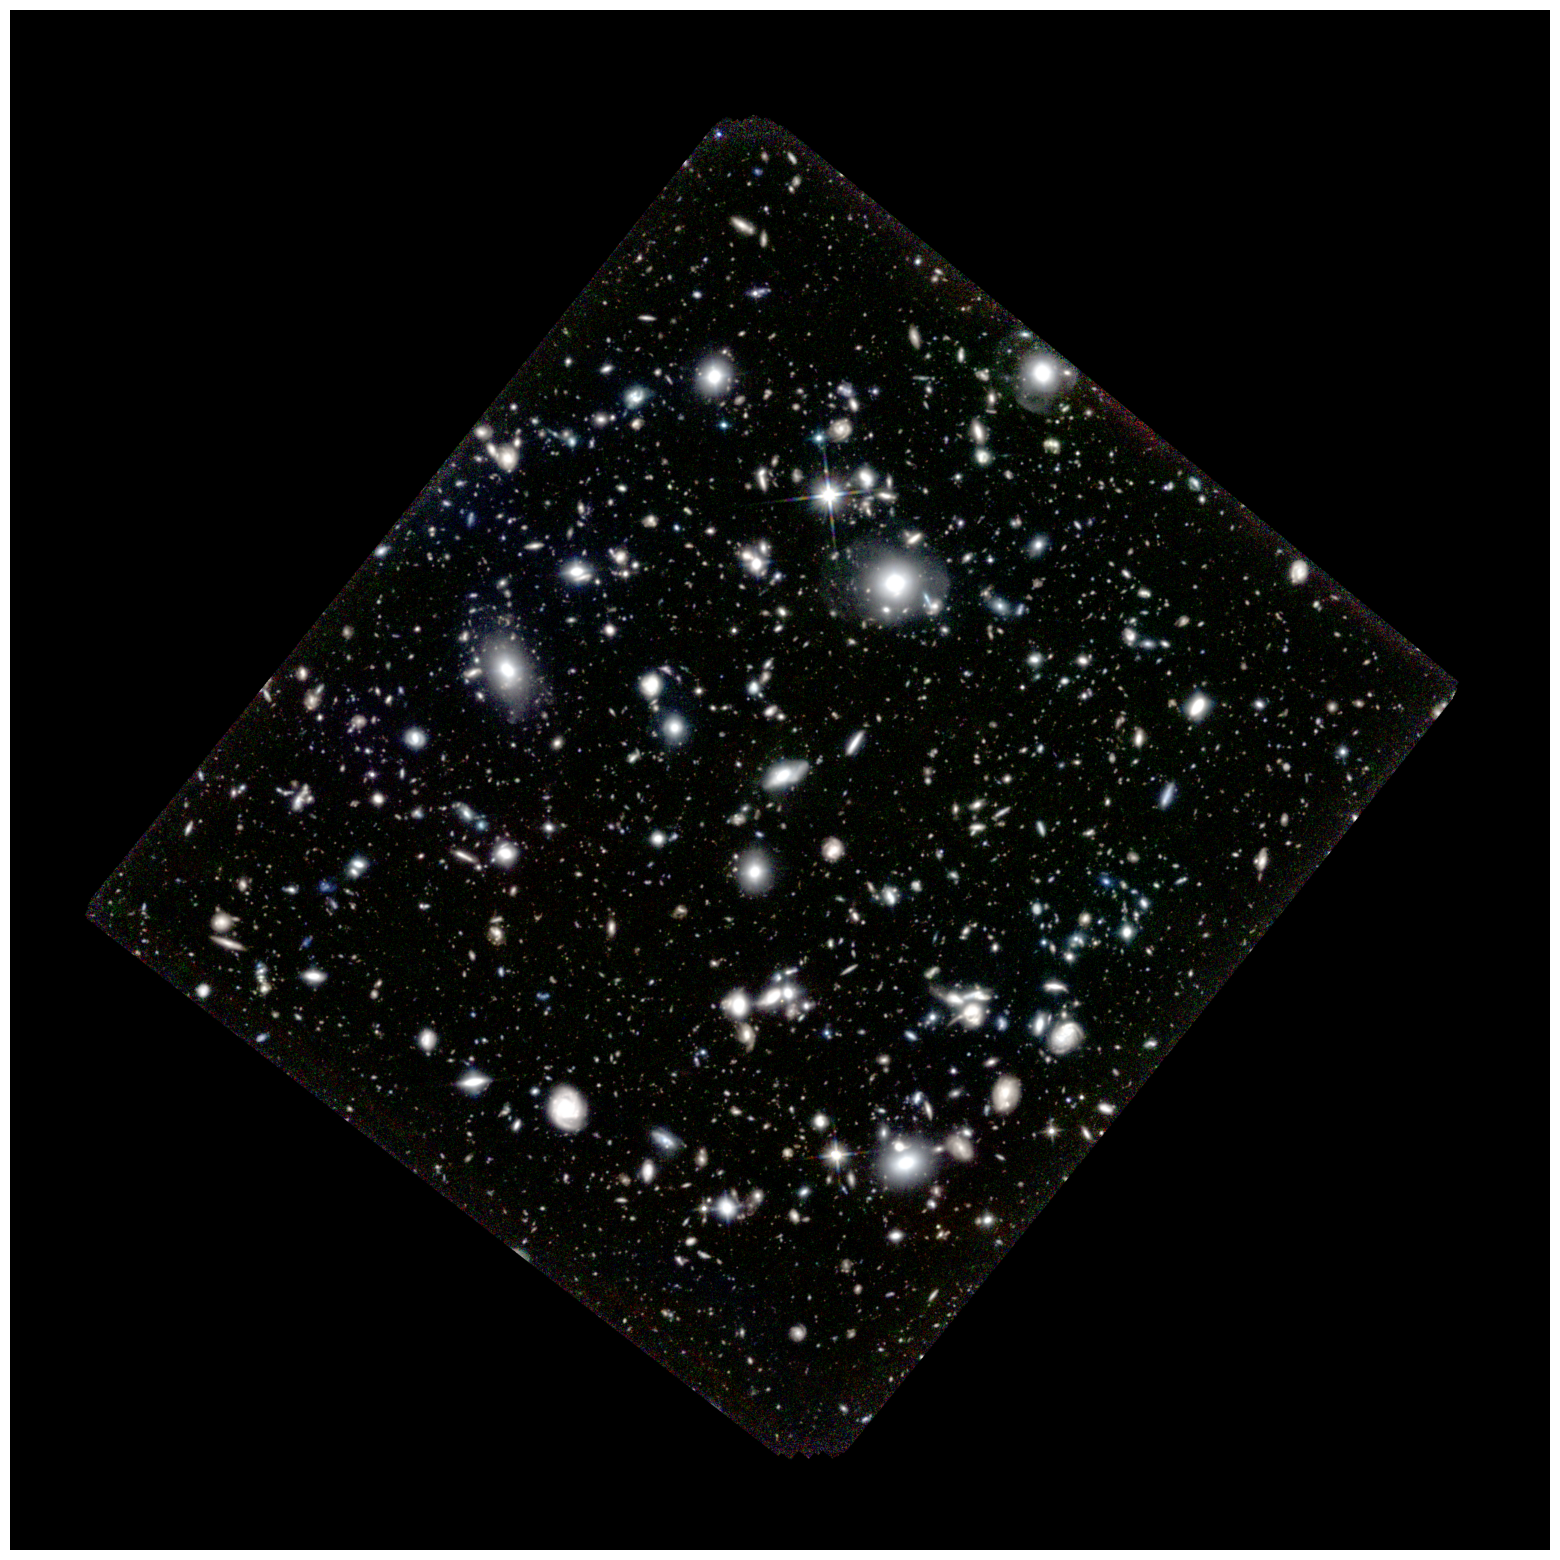

In [22]:
f, ax = plt.subplots(1, 1, figsize=(20, 20))
ax.axis('off')
ax.imshow(rgb)

plt.savefig("falsecolor.png", format='png')

This is where the outlier is on the image. Should've known it was the one with sparkle lines! (That's the technical term.)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


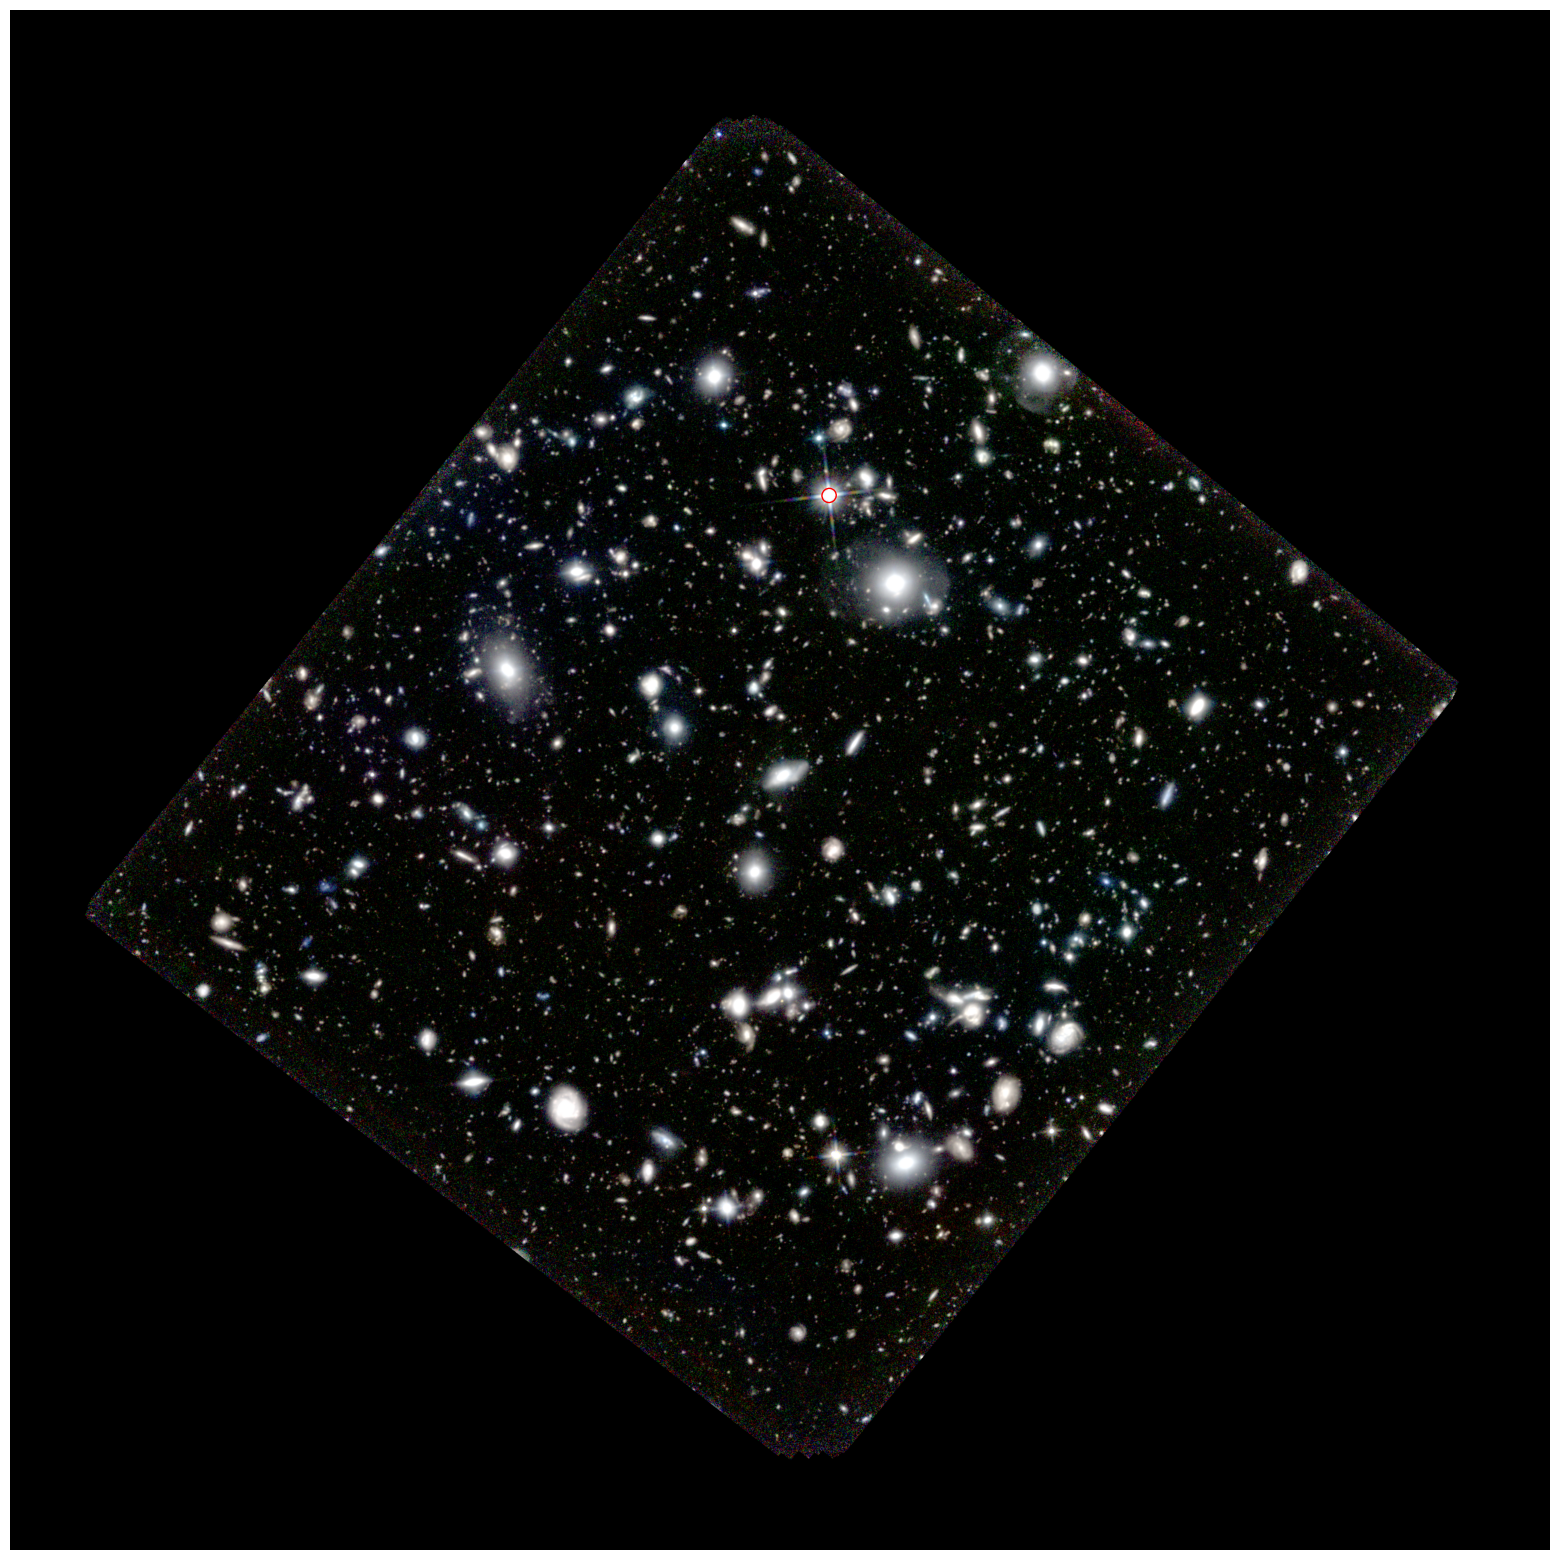

In [23]:
f, ax = plt.subplots(1, 1, figsize=(20, 20))
ax.axis('off')
ax.imshow(rgb)

# plot an ellipse for each object
i = flux.argmax()
e = Ellipse(xy=(objects['x'][i], objects['y'][i]),
             width=6*objects['a'][i],
             height=6*objects['b'][i],
             angle=objects['theta'][i] * 180. / np.pi)
e.set_facecolor('none')
e.set_edgecolor('red')
ax.add_artist(e)
plt.savefig('HUDF_5')